##Turnning on GPU in Colab

In [ ]:

# Check environment
import tensorflow as tf, platform, sys
print("TF:", tf.__version__, "| Python:", sys.version.split()[0], "| GPU:", tf.config.list_physical_devices('GPU'))  # Check TensorFlow and GPU

TF: 2.19.0 | Python: 3.12.11 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##Setting up & Drive mount

Extracting the ZIP (auto-detect the uploaded filename) and verify paths

In [4]:
# Extract to /content/brain_tumor_dataset
from google.colab import files
import zipfile, os

uploaded = files.upload()                # you already clicked once; safe to run again
zip_name = next(iter(uploaded))          # gets "Brain_Tumour_Datasets.zip"
extract_root = "/content/Brain_Tumour_Datasets"
os.makedirs(extract_root, exist_ok=True)

with zipfile.ZipFile(zip_name, "r") as zf:
    zf.extractall(extract_root)

# Inspect folders (you should see .../Brain_Tumour_Datasets/Training and /Testing)
!find /content/brain_tumor_dataset -maxdepth 2 -type d -print


Saving Brain_Tumour_Datasets.zip to Brain_Tumour_Datasets (1).zip
find: ‘/content/brain_tumor_dataset’: No such file or directory


Then set paths (matches the folder inside the ZIP)

In [ ]:
# This matches where I actually extracted
DATA_DIR = "/content/Brain_Tumour_Datasets"   # Dataset root
TRAIN_DIR = f"{DATA_DIR}/Training"       # Training data
TEST_DIR  = f"{DATA_DIR}/Testing"        # Testing data

# sanity check
!find "$DATA_DIR" -maxdepth 2 -type d -print   # Check dataset structure


/content/Brain_Tumour_Datasets
/content/Brain_Tumour_Datasets/Training
/content/Brain_Tumour_Datasets/Training/notumor
/content/Brain_Tumour_Datasets/Training/pituitary
/content/Brain_Tumour_Datasets/Training/meningioma
/content/Brain_Tumour_Datasets/Training/glioma
/content/Brain_Tumour_Datasets/Testing
/content/Brain_Tumour_Datasets/Testing/notumor
/content/Brain_Tumour_Datasets/Testing/pituitary
/content/Brain_Tumour_Datasets/Testing/meningioma
/content/Brain_Tumour_Datasets/Testing/glioma


##Imports (uses existing TRAIN_DIR/TEST_DIR)

In [ ]:
# Fred | Brain Tumor MRI EDA — config


"""
Brain Tumor MRI — quick EDA helpers

This script:
1) Locates the train/test folders inside Brain_Tumour_Datasets.
2) Lists class subfolders and verifies the directory layout exists.
3) Counts images per (split, class) using a fixed set of extensions.
4) Shows a pivot table of counts and a stacked bar chart (train vs test).
"""

# -------------------------------
# Imports used below:
#   - os / glob / pathlib: filesystem operations
#   - random / numpy: seeds + array utilities
#   - pandas: tabular counts/pivoting
#   - PIL.Image: image opening (not decoding pixels here, just used by later steps)
#   - matplotlib: simple bar chart
# -------------------------------


import os, glob, random, math, pathlib, collections   
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# -------------------------------
# Paths to the dataset.
# Expect this directory layout (standard Kaggle/Colab copy):
#   /content/Brain_Tumour_Datasets/
#       Training/
#           glioma/ meningioma/ notumor/ pituitary/
#       Testing/
#           glioma/ meningioma/ notumor/ pituitary/
# -------------------------------
# paths (already extracted)
DATA_DIR  = "/content/Brain_Tumour_Datasets"
TRAIN_DIR = f"{DATA_DIR}/Training"
TEST_DIR  = f"{DATA_DIR}/Testing"

# -------------------------------
# Reproducibility: seed Python's RNG and NumPy's RNG.
# (Useful when later sampling files for quick checks.)
# -------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# -------------------------------
# File extensions we consider "images" for counting.
# Lowercased suffix check is used when scanning folders.
# -------------------------------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# -------------------------------
# Sanity checks that the train/test roots exist.
# If this assert fires, DATA_DIR is wrong or the ZIP wasn't extracted as expected.
# -------------------------------
assert os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR), "Fix DATA_DIR if these are missing."

# -------------------------------
# List class names by enumerating subdirectories inside TRAIN_DIR.
# next(os.walk(TRAIN_DIR))[1] returns the list of subfolder names at that level.
# sorted(...) to get a stable order: ['glioma','meningioma','notumor','pituitary']
# -------------------------------
CLASSES = sorted(next(os.walk(TRAIN_DIR))[1])
print("Classes:", CLASSES)



Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


##Counts by split and class

In [ ]:
# ============================================================
# Counts per split/class and a simple visualization
# ============================================================

# -------------------------------
# Utility: list all image files for a given (root, class) pair.
# Uses pathlib for clean path handling and suffix filtering via IMG_EXTS.
# Returns a list of absolute-like strings for consistency.
# -------------------------------
def list_images(root, cls):
    p = pathlib.Path(root)/cls
    return [str(x) for x in p.iterdir() if x.suffix.lower() in IMG_EXTS]


# -------------------------------
# Build a small table of counts:
#   rows = [
#       {"split": "train", "class": "glioma",     "count": 1321},
#       {"split": "train", "class": "meningioma", "count": 1339},
#       ...
#       {"split": "test",  "class": "glioma",     "count": 300},
#       ...
#   ]
# Then convert to a DataFrame and pivot for a class x (train/test) table.
# -------------------------------
rows = []
for split, root in [("train", TRAIN_DIR), ("test", TEST_DIR)]:
    for cls in CLASSES:
        rows.append({"split": split, "class": cls, "count": len(list_images(root, cls))})
        
# Build DataFrame and standardize ordering
df_counts = pd.DataFrame(rows).sort_values(["split","class"]).reset_index(drop=True)
display(df_counts.pivot(index="class", columns="split", values="count").fillna(0).astype(int))

split,test,train
class,,
glioma,300,1321
meningioma,306,1339
notumor,405,1595
pituitary,300,1457


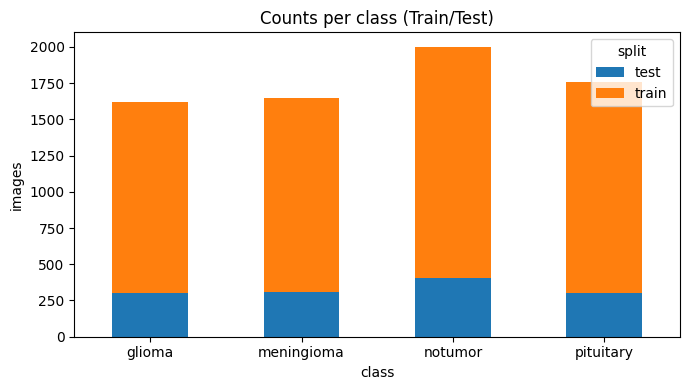

In [ ]:
# bar chart (train vs test)
# -------------------------------
# Bar chart: stacked (train + test) per class.
# wide is the same pivot used above; we plot directly from it.
# -------------------------------
plt.figure(figsize=(7,4))
wide = df_counts.pivot(index="class", columns="split", values="count").fillna(0)
wide.plot(kind="bar", stacked=True, ax=plt.gca())
plt.ylabel("images"); plt.title("Counts per class (Train/Test)"); plt.xticks(rotation=0)
plt.tight_layout(); plt.show()


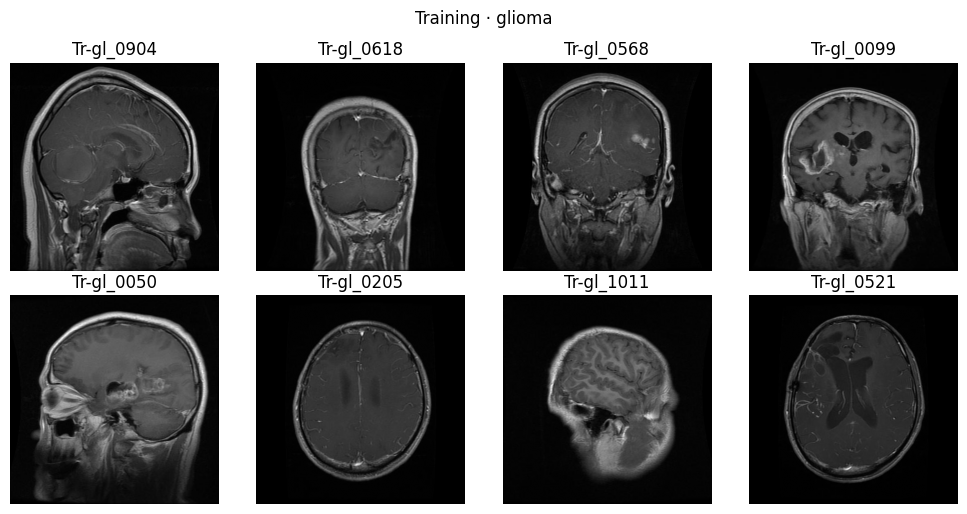

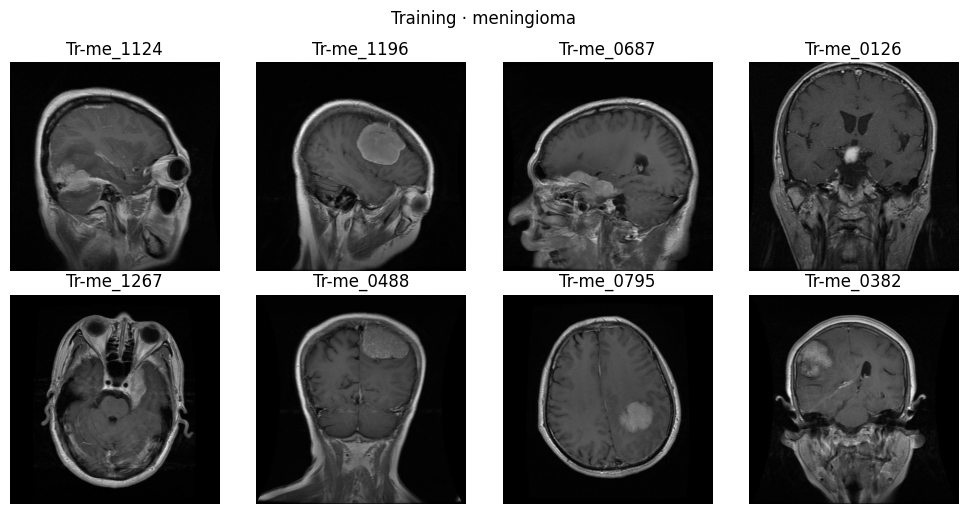

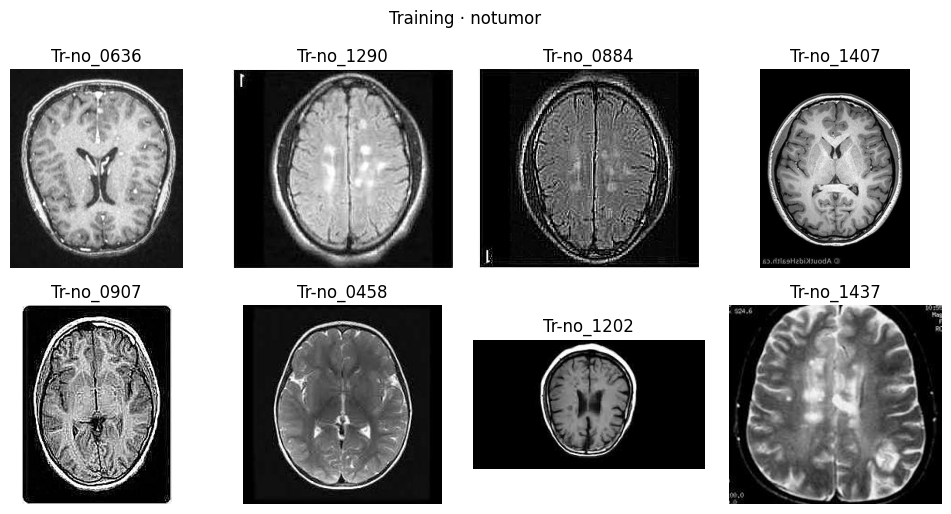

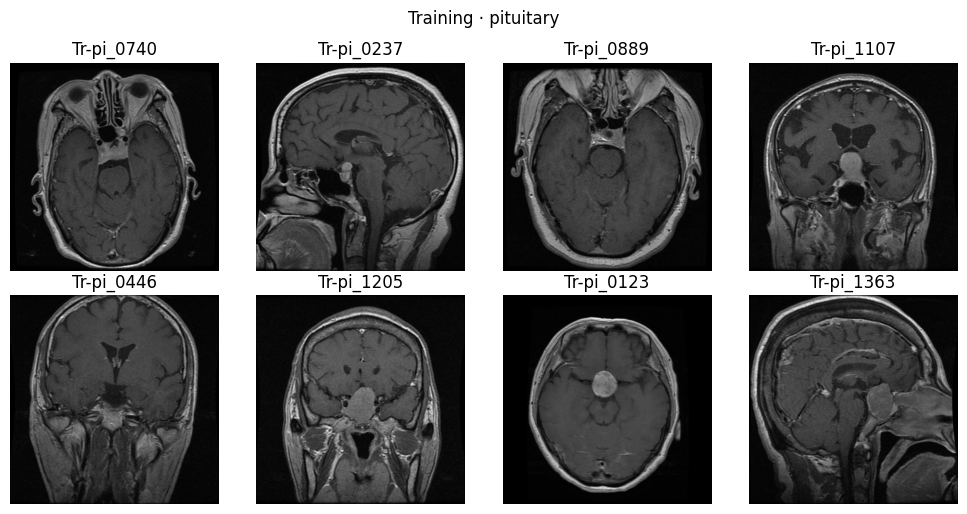

In [ ]:
# montage per class (quick visual)
def show_grid(root, cls, n=8, cols=4):
    """
    Sample up to n images from root/cls and display a small grid.
    Shows grayscale properly (cmap='gray') to avoid misleading color ramps.
    """
    files = list_images(root, cls)
    if not files: return
    files = random.sample(files, min(n, len(files)))
    rows = math.ceil(len(files)/cols)
    plt.figure(figsize=(10, 2.6*rows))
    for i, fp in enumerate(files, 1):
        with Image.open(fp) as im:
            plt.subplot(rows, cols, i)
            if im.mode == "L":                     # single-channel MRI
                plt.imshow(im, cmap="gray")
            else:                                    # RGB or others -> show as-is
                plt.imshow(im)
            plt.axis("off")
            plt.title(pathlib.Path(fp).stem[:18])    # short filename
    plt.suptitle(f"{pathlib.Path(root).name} · {cls}")
    plt.tight_layout(); plt.show()

# Flip through each class in Training/; quick “does this look right?” pass.
for cls in CLASSES:
    show_grid(TRAIN_DIR, cls, n=8)


Most common sizes:


,,count
w,h,
512,512,4742
225,225,332
630,630,90
236,236,81
201,251,58
228,221,51
232,217,50
300,168,49
442,442,46


Aspect ratio distribution:


,count
aspect,
1.000,5415
0.801,59
1.032,52
1.069,52
1.786,49
1.026,49
0.758,44
0.794,43
1.023,41


Mode counts:


,count
mode,
RGB,3926
L,3093
RGBA,3
P,1


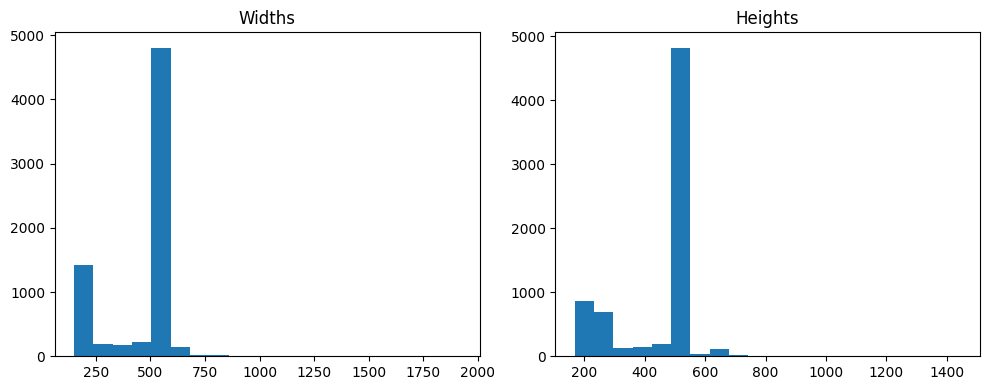

In [ ]:
# -----------------------------------------------------
# dimensions, aspect ratios, and image modes (metadata)
# -----------------------------------------------------
def image_shapes(root):
    """
    Walk each class under `root`, collect (w, h, mode) for every readable file.
    If an image can’t be opened, mark it as CORRUPT so counts still add up.
    """
    rows = []
    for cls in CLASSES:
        for fp in list_images(root, cls):
            try:
                with Image.open(fp) as im:
                    rows.append({
                        "split": pathlib.Path(root).name,
                        "class": cls,
                        "w": im.width, "h": im.height,
                        "mode": im.mode                     # "L", "RGB", "RGBA", etc
                    })
            except Exception:
                rows.append({"split": pathlib.Path(root).name,"class":cls,"w":None,"h":None,"mode":"CORRUPT"})
    return pd.DataFrame(rows)

# Combine train+test summaries
df_shapes = pd.concat([image_shapes(TRAIN_DIR), image_shapes(TEST_DIR)], ignore_index=True)

# Drop rows where open failed (w/h None) for numeric histograms below
df_shapes.dropna(subset=["w","h"], inplace=True)

# Aspect ratio helps spot stretched/cropped inconsistencies (round to tidy bins)
df_shapes["aspect"] = (df_shapes["w"]/df_shapes["h"]).round(3)

# Quick histograms for widths and heights — large spikes usually indicate standard
print("Most common sizes:")
display(df_shapes.value_counts(["w","h"]).head(10))
print("Aspect ratio distribution:")
display(df_shapes["aspect"].value_counts().head(10))
print("Mode counts:")
display(df_shapes["mode"].value_counts())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(df_shapes["w"], bins=20); plt.title("Widths")
plt.subplot(1,2,2); plt.hist(df_shapes["h"], bins=20); plt.title("Heights")
plt.tight_layout(); plt.show()


In [ ]:
# Fred | fake-RGB check (fixed)

# ---------------------------------------
# check for “fake RGB” (L replicated to 3)
# ---------------------------------------

 
# Return True if an image is effectively grayscale-in-RGB:
#    For a random subset of pixels, all three channels are equal beyond `thresh`.
#  The image is read as RGB so every file becomes 3-channel consistently

def is_fake_rgb(fp, sample=2000, thresh=0.99):
    # Convert to RGB so RGBA/P/L all become 3-channel
    with Image.open(fp) as im:
        arr = np.asarray(im.convert("RGB"))

    h, w, _ = arr.shape
    k = min(sample, h * w)            # same k for both axes
    ys = np.random.randint(0, h, size=k)  # random rows
    xs = np.random.randint(0, w, size=k)    # random cols
    sub = arr[ys, xs]                 # shape (k, 3)
    same = (sub[:, 0] == sub[:, 1]) & (sub[:, 1] == sub[:, 2])     # channel equality
    return float(np.mean(same)) > thresh

# run on a stratified sample from your training set
sample_files = []
for cls in CLASSES:
    files = list_images(TRAIN_DIR, cls)
    sample_files += random.sample(files, min(60, len(files)))

fake_rgb_ratio = np.mean([is_fake_rgb(fp) for fp in sample_files])
print(f"Approx. fraction of RGB images that are grayscale-in-RGB: {fake_rgb_ratio:.2f}")


Approx. fraction of RGB images that are grayscale-in-RGB: 0.98


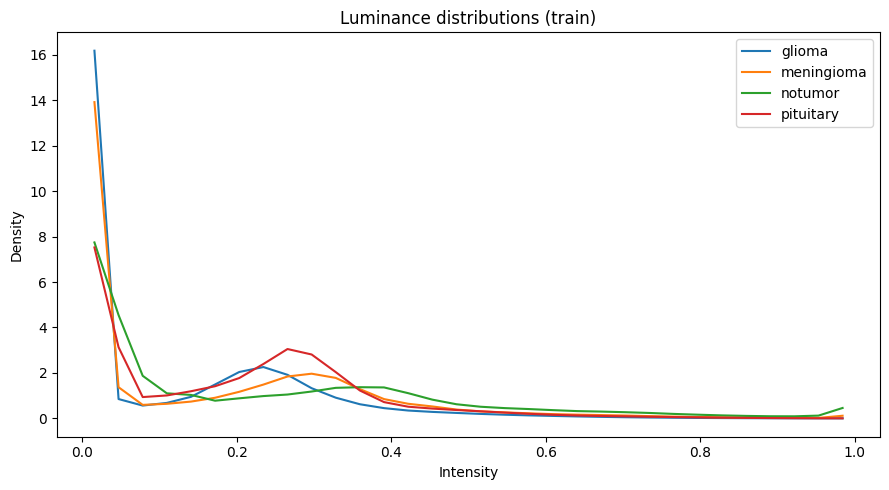

In [ ]:
# luminance histograms per class (sampled)
# -----------------------------------------

def luminance_values(filepaths, limit=120):
    """
    Convert up to `limit` images to L (grayscale) and collect normalized pixel values.
    Used to compare intensity distributions between classes.
    """
    vals = []
    for fp in random.sample(filepaths, min(limit, len(filepaths))):
        try:
            with Image.open(fp) as im:
                arr = np.asarray(im.convert("L")).astype(np.float32)/255.0
                vals.extend(arr.ravel().tolist())
        except Exception:
            # Skip unreadable files silently; they were already flagged above
            pass
    return np.array(vals)

plt.figure(figsize=(9,5))
bins = np.linspace(0,1,33)  # consistent edges across classes
for cls in CLASSES:
    files = list_images(TRAIN_DIR, cls)
    v = luminance_values(files)
    if len(v):
        hist, _ = np.histogram(v, bins=bins, density=True)
        centers = (bins[:-1]+bins[1:])/2
        plt.plot(centers, hist, label=cls)
plt.xlabel("Intensity"); plt.ylabel("Density"); plt.title("Luminance distributions (train)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# corruption check
bad = []
for root in [TRAIN_DIR, TEST_DIR]:  # check both train and test directories
    for cls in CLASSES:              # iterate over each class
        for fp in list_images(root, cls):   # list images in the current class
            try:
                with Image.open(fp) as im:  # open image file
                    im.verify()             # verify image integrity
            except Exception:
                bad.append(fp)

print("Corrupted files:", len(bad))
bad[:10]


Corrupted files: 0


[]

In [ ]:
# simple near-duplicate scan using average hash (no extra deps)
def ahash_bits(fp, hash_size=8):    # compute average hash bits for an image
    with Image.open(fp) as im:     # open image file
        im = im.convert("L").resize((hash_size, hash_size))   # convert to grayscale and resize
        arr = np.asarray(im, dtype=np.float32)   # convert to array
    avg = arr.mean()
    bits = (arr > avg).reshape(-1)    # thresholding 
    return "".join("1" if b else "0" for b in bits)

def scan_dups(root, max_per_class=500):  # scan for duplicates
    buckets = collections.defaultdict(list)  # create a default dictionary to hold image paths
    for cls in CLASSES:   # iterate over each class
        files = list_images(root, cls)
        files = random.sample(files, min(max_per_class, len(files)))  # limit to max_per_class
        for fp in files:
            try:
                h = ahash_bits(fp)
                buckets[h].append(fp)
            except Exception:
                pass
    dups = [v for v in buckets.values() if len(v) > 1]  # find duplicate groups
    return dups

dups_train = scan_dups(TRAIN_DIR)
dups_test  = scan_dups(TEST_DIR)
print(f"Potential duplicate groups (train): {len(dups_train)} | (test): {len(dups_test)}")  # find duplicate groups
dups_train[:1]  # inspect a sample group


Potential duplicate groups (train): 259 | (test): 154


[['/content/Brain_Tumour_Datasets/Training/glioma/Tr-gl_0592.jpg',
  '/content/Brain_Tumour_Datasets/Training/glioma/Tr-gl_0591.jpg',
  '/content/Brain_Tumour_Datasets/Training/glioma/Tr-gl_0358.jpg',
  '/content/Brain_Tumour_Datasets/Training/glioma/Tr-gl_0096.jpg']]

Square images → use IMG_SIZE = (256,256).

98% grayscale-in-RGB → keep loader in RGB (pretrained backbones expect 3-ch).

Duplicates detected → clean cross-split duplicates before training.

In [ ]:
# Fred | cross-split duplicate cleanup (average hash)
import os, shutil, collections
from PIL import Image
import numpy as np, pathlib

DATA_DIR  = "/content/Brain_Tumour_Datasets"   # dataset directory
TRAIN_DIR = f"{DATA_DIR}/Training"            # training directory
TEST_DIR  = f"{DATA_DIR}/Testing"             # testing directory
QUAR_DIR  = "/content/dup_quarantine"         # quarantine directory

def list_images(root, cls):    # list images in a class directory
    p = pathlib.Path(root)/cls  # class directory path
    return [str(x) for x in p.iterdir() if x.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}]  # image file extensions

CLASSES = sorted(next(os.walk(TRAIN_DIR))[1])    # class names

def ahash_bits(fp, hash_size=8):   # compute average hash bits for an image
    with Image.open(fp) as im:     # open image file
        im = im.convert("L").resize((hash_size, hash_size))   # convert to grayscale and resize
        arr = np.asarray(im, dtype=np.float32)   # convert to array
    avg = arr.mean()
    bits = (arr > avg).reshape(-1)    # thresholding
    return "".join("1" if b else "0" for b in bits)  # return hash

def make_hash_map(root):  # create a hash map for images
    m = collections.defaultdict(list)  # create a default dictionary to hold image paths
    for cls in CLASSES:     # iterate over each class
        for fp in list_images(root, cls):   # list images in the current class
            try:
                h = ahash_bits(fp)      # compute hash
                m[h].append((cls, fp))
            except Exception:
                pass
    return m

train_hashes = make_hash_map(TRAIN_DIR)  # create hash map for training images
test_hashes  = make_hash_map(TEST_DIR)   # create hash map for testing images

overlap = set(train_hashes.keys()) & set(test_hashes.keys())  # find overlapping hashes
print("hashes in both splits:", len(overlap))                 # find overlapping hashes

# moving any overlapping images from TEST to quarantine (prevents leakage)
moved = 0
for h in overlap:
    for cls, fp in test_hashes[h]:
        dest_dir = os.path.join(QUAR_DIR, "Testing", cls)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.move(fp, os.path.join(dest_dir, os.path.basename(fp)))
        moved += 1
print("moved from Testing -> quarantine:", moved)


hashes in both splits: 509
moved from Testing -> quarantine: 946


TF datasets (train/val/test) + class weights

In [ ]:
import tensorflow as tf, numpy as np, os
SEED = 42
IMG_SIZE = (256,256)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    validation_split=VAL_SPLIT, subset="training", seed=SEED)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    validation_split=VAL_SPLIT, subset="validation", seed=SEED)

# Create testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    shuffle=False)

# Create a mapping from class names to class indices
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# class weights
y_train = [np.argmax(y.numpy()) for _, y in train_ds.unbatch()]
unique, counts = np.unique(y_train, return_counts=True)
class_weight = {int(k): float(len(y_train)/(len(unique)*c)) for k,c in zip(unique, counts)}
class_weight

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 365 files belonging to 4 classes.


{0: 1.0608170844939646,
 1: 1.048165137614679,
 2: 0.9161988773055333,
 3: 0.9883217993079585}

## Baseline model (EfficientNetB0, frozen backbone)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# transfer learning with EfficientNetB0
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="aug")

# Create base model
base = keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(*IMG_SIZE,3))  # create base model architecture 
base.trainable = False

# Create the model 
inp = keras.Input(shape=(*IMG_SIZE,3))
x = keras.applications.efficientnet.preprocess_input(inp)
x = data_aug(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inp, out)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3),  # create optimizer
              loss="categorical_crossentropy",        # create loss function
              metrics=["accuracy"])                   # create evaluation metric

ckpt_dir = "/content/model_ckpts"; os.makedirs(ckpt_dir, exist_ok=True)   # create checkpoint directory
callbacks = [
    keras.callbacks.ModelCheckpoint(f"{ckpt_dir}/best.keras",
                                    monitor="val_accuracy", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2),
]

# Train the model 
history = model.fit(train_ds, validation_data=val_ds, epochs=20,
                    callbacks=callbacks, class_weight=class_weight)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.6312 - loss: 0.9144 - val_accuracy: 0.8047 - val_loss: 0.4948 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.8408 - loss: 0.4732 - val_accuracy: 0.8135 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8636 - loss: 0.4030 - val_accuracy: 0.8266 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.8748 - loss: 0.3704 - val_accuracy: 0.8371 - val_loss: 0.4033 - learning_rate: 0.0010
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.8670 - loss: 0.3562 - val_accuracy: 0.8441 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.8850 - loss: 0.3232 - val_accuracy: 0.8476 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 7/20
143/143 

##Fine-tune top layers

In [ ]:
# unfreeze top ~30%
for layer in base.layers[int(len(base.layers)*0.7):]:   # this code unfreezes the top 30% of the base model
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-4),    # this code creates a new optimizer with a lower learning rate
              loss="categorical_crossentropy", metrics=["accuracy"])    # this code creates a new loss function and evaluation metric

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=10,     # this code trains the model with the new settings
                       callbacks=callbacks, class_weight=class_weight)  # this code applies the callbacks and class weights


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step - accuracy: 0.8398 - loss: 0.4704 - val_accuracy: 0.9133 - val_loss: 0.2201 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9366 - loss: 0.1763 - val_accuracy: 0.9422 - val_loss: 0.1471 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.9667 - loss: 0.1097 - val_accuracy: 0.9527 - val_loss: 0.1302 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.9714 - loss: 0.0832 - val_accuracy: 0.9623 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9831 - loss: 0.0526 - val_accuracy: 0.9615 - val_loss: 0.0938 - learning_rate: 1.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.9845 - loss: 0.0471 - val_accuracy: 0.9711 - val_loss: 0.0849 - learning_rate: 1.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 16

## Evaluation + confusion matrix + a few mistakes

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9728 - loss: 0.0563
test_acc: 0.9781
              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       107
  meningioma       0.95      0.98      0.96        96
     notumor       1.00      1.00      1.00        16
   pituitary       0.99      1.00      1.00       146

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365



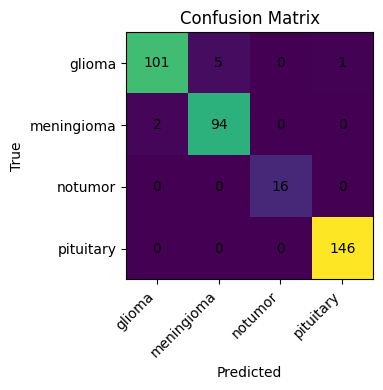

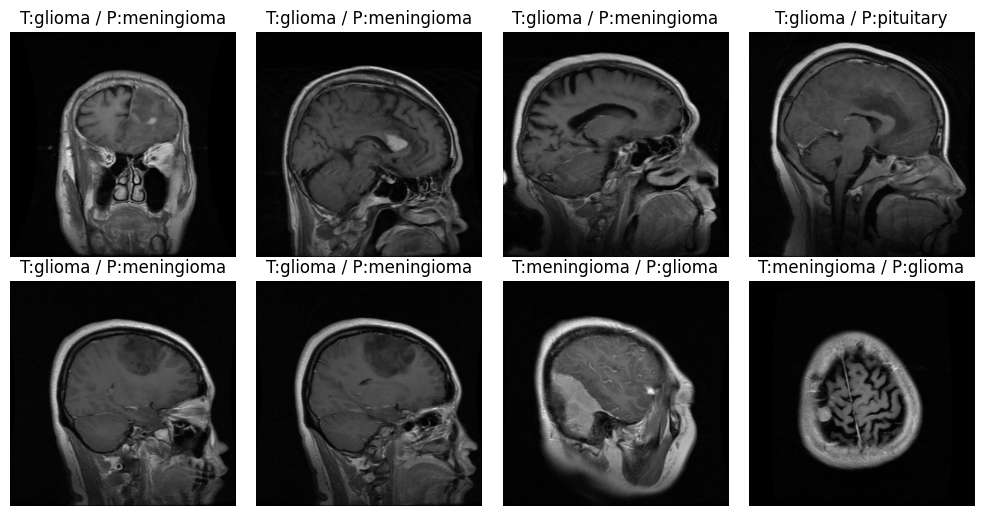

In [ ]:
import numpy as np, matplotlib.pyplot as plt                         # this library is for data visualization
from sklearn.metrics import classification_report, confusion_matrix   

test_loss, test_acc = model.evaluate(test_ds)       # evaluate the model on the test dataset
print("test_acc:", round(test_acc,4))              #  this prints the test accuracy

y_true = [np.argmax(y.numpy()) for _, y in test_ds.unbatch()]    # this code gets the true labels
y_prob = model.predict(test_ds, verbose=0)        # this code gets the predicted probabilities
y_pred = y_prob.argmax(1)                           # this code gets the predicted labels

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# show a few misclassified examples
import itertools
it = iter(test_ds.unbatch().as_numpy_iterator())
images = []; labels = []
for img, lab in itertools.islice(it, len(y_pred)):
    images.append(img); labels.append(np.argmax(lab))
miss_idx = [i for i,(t,p) in enumerate(zip(labels, y_pred)) if t!=p][:12]

# Plot misclassified examples
cols=4; rows=int(np.ceil(len(miss_idx)/cols)) # this code calculates the number of rows needed for the plot
plt.figure(figsize=(10, 2.6*rows))           # this code sets the figure size for the plot
for k,i in enumerate(miss_idx,1):             # 
    plt.subplot(rows, cols, k)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
    plt.title(f"T:{class_names[labels[i]]} / P:{class_names[y_pred[i]]}")   # this code sets the title for each subplot
plt.tight_layout(); plt.show()


## Save/export (SavedModel, H5, TFLite)

In [26]:
import os, json, time, shutil, zipfile, tensorflow as tf

# === config ===
STAMP = time.strftime("%Y-%m-%d_%H-%M")
SAVE_DIR = f"/content/brain_tumor_efficientnetb0_{IMG_SIZE[0]}_{STAMP}"
os.makedirs(SAVE_DIR, exist_ok=True)

KERAS_PATH      = os.path.join(SAVE_DIR, "model.keras")      # native Keras format (recommended)
H5_PATH         = os.path.join(SAVE_DIR, "model.h5")         # optional legacy single-file
SAVEDMODEL_DIR  = os.path.join(SAVE_DIR, "saved_model")      # for TFLite/TF-Serving

# saving the models
model.save(KERAS_PATH)          # Keras v3 format
model.save(H5_PATH)             # optional; okay to keep both
model.export(SAVEDMODEL_DIR)    # SavedModel directory (Keras 3 API)

# metadata (for your Streamlit app)
meta = {
    "img_size": list(IMG_SIZE),
    "classes": class_names,
    "has_preprocess_in_model": True
}
with open(os.path.join(SAVE_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

# zip for download
ZIP_PATH = f"{SAVE_DIR}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(SAVE_DIR):
        for name in files:
            fp = os.path.join(root, name)
            z.write(fp, arcname=os.path.relpath(fp, SAVE_DIR))
print("Zipped:", ZIP_PATH)


Saved artifact at '/content/brain_tumor_efficientnetb0_256_2025-08-25_15-03/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135929566382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929566386064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929566385296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929567061264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135929567061456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135929566380496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929569606352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929569606928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135929566380112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359295663

##Download just the needed files from Colab

In [27]:
from google.colab import files, output
files.download(KERAS_PATH)                         # downloads model.keras
files.download(os.path.join(SAVE_DIR, "meta.json")) # downloads meta.json (size + classes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downlaoding the saved model zip

In [29]:
FOLDER = "/content/brain_tumor_efficientnetb0_256_2025-08-25_15-03"

# sanity check: show what's inside
!ls -lah "$FOLDER"

# zip ONLY the SavedModel dir
!cd "$FOLDER" && zip -r saved_model.zip saved_model

# download
from google.colab import files
files.download(f"{FOLDER}/saved_model.zip")


total 80M
drwxr-xr-x 3 root root 4.0K Aug 25 15:03 .
drwxr-xr-x 1 root root 4.0K Aug 25 15:03 ..
-rw-r--r-- 1 root root  158 Aug 25 15:03 meta.json
-rw-r--r-- 1 root root  40M Aug 25 15:03 model.h5
-rw-r--r-- 1 root root  40M Aug 25 15:03 model.keras
drwxr-xr-x 4 root root 4.0K Aug 25 15:03 saved_model
  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>